In [1]:
%matplotlib inline

import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import IPython

import sys

sys.path.append('.')

from niveau_nappe_core import *

sns.set()

In [2]:
# The horizon size
label_width = 93

# An history length of 
input_width = 100

# Number of feature values to predict at once
shift = label_width

# batch size
batch_size = 64

# fontsizes for figures
FONTSIZE = 15
TITLE_FONTSIZE = 20

In [3]:
sources = pd.read_csv('../data_collection/dataset_stations.csv', delimiter=',', index_col=0)
sources.head()

,bss,x,y,geometry,dpt,prof,alt,masse_eau,codes_bdlisa,CodeEH,InclusEH,EtatEH,NatureEH,MilieuEH,ThemeEH,OrigineEH
0,10402X0177/JOURDA,3.387383,43.336667,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",34,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,09654X0569/CNRP20,4.607080,43.848274,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",30,18.0,12.0,"[""Alluvions du RhÃ´ne du confluent de la Duran...",712AJ05,712AJ05,712AJ,2,5.0,1,1.0,1.0
2,02581X0104/P18,2.543903,48.523357,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",77,34.0,60.0,NaN,113AA01,113AA01,113AA,3,5.0,5,2.0,1.0
3,02913X0024/P,1.640479,48.401585,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",28,12.0,153.4,['Multicouches craie du SÃ©no-turonien et calc...,107AA01,107AA01,107AA,3,5.0,5,2.0,1.0
4,00182X0031/P,2.258327,50.544651,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",62,62.8,180.0,"[""Craie de l'Artois et de la vallÃ©e de la Lys""]",121BD01,121BD01,121BD,3,5.0,4,2.0,1.0


In [4]:
all_data = pd.read_csv('../data_collection/dataset_nomissing_linear.csv', delimiter=',', index_col=0, parse_dates=['time'])
all_data.set_index('bss', drop=True, inplace=True)
all_data.head()

/Users/michael/opt/miniconda3/envs/defiegc2021/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,time,tp,e,p
bss,,,,
00061X0117/PZ1,2015-01-01,0.000015,-0.005951,17.43
00061X0117/PZ1,2015-01-02,0.000791,-0.012997,17.38
00061X0117/PZ1,2015-01-03,0.012880,-0.009395,17.31
00061X0117/PZ1,2015-01-04,0.000005,-0.007145,17.26
00061X0117/PZ1,2015-01-05,0.000072,-0.002743,17.19


In [5]:
piezo_without_data = set(sources.bss).difference(all_data.index)
print(len(piezo_without_data), 'over', sources.shape[0], 'Piezometers without data')

1481 over 2810 Piezometers without data


In [6]:
print(all_data.shape)

(3185613, 4)


In [7]:
all_data.describe()

,tp,e,p
count,3.185613e+06,3.073977e+06,3.185613e+06
mean,2.365148e-03,-2.196965e-02,1.744470e+01
std,4.660794e-03,1.502670e-02,4.669572e+01
min,-2.235174e-08,-1.275453e-01,-2.010000e+01
25%,1.165084e-06,-3.268468e-02,3.480000e+00
50%,3.124950e-04,-1.955294e-02,8.770000e+00
75%,2.621830e-03,-9.353379e-03,2.248000e+01
max,1.504297e-01,1.311594e-02,1.151740e+03


In [8]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3185613 entries, 00061X0117/PZ1 to BSS002PTEJ/MONTFR
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   tp      float64       
 2   e       float64       
 3   p       float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 121.5+ MB


In [9]:
code_bss = "00471X0095/PZ2013"
bss_id = "BSS000EBLL"
data = all_data.loc[code_bss].set_index('time')
data = data.sort_index()

data.head()

,tp,e,p
time,,,
2015-01-01,0.000002,-0.002716,11.65
2015-01-02,0.000968,-0.006637,11.61
2015-01-03,0.009156,-0.001883,11.56
2015-01-04,0.000030,-0.003922,11.53
2015-01-05,0.000032,-0.001558,11.49


In [10]:
data.describe()

,tp,e,p
count,2.397000e+03,2313.000000,2397.000000
mean,2.104166e-03,-0.019895,11.799458
std,3.560893e-03,0.013659,2.502883
min,-2.235174e-08,-0.063269,5.850000
25%,1.803786e-05,-0.029545,9.810000
50%,4.635220e-04,-0.017830,12.310000
75%,2.717312e-03,-0.008171,13.780000
max,2.918985e-02,0.004677,15.950000


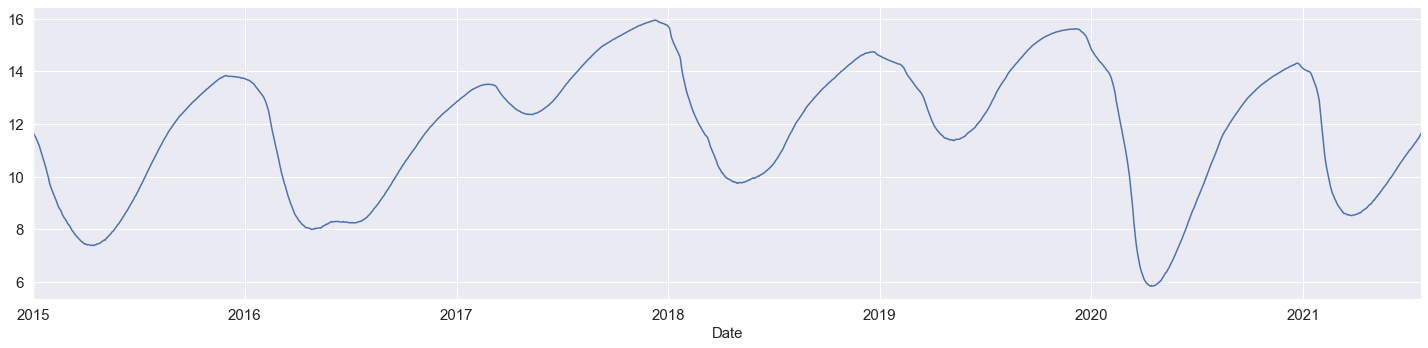

In [19]:
ax = data.p.plot(figsize=(20, 5), fontsize=FONTSIZE)
ax.set_xlabel('Date', fontsize=FONTSIZE)
plt.tight_layout()
ax.get_figure().savefig(f'Images/piezometre_{bss_id}.pdf')

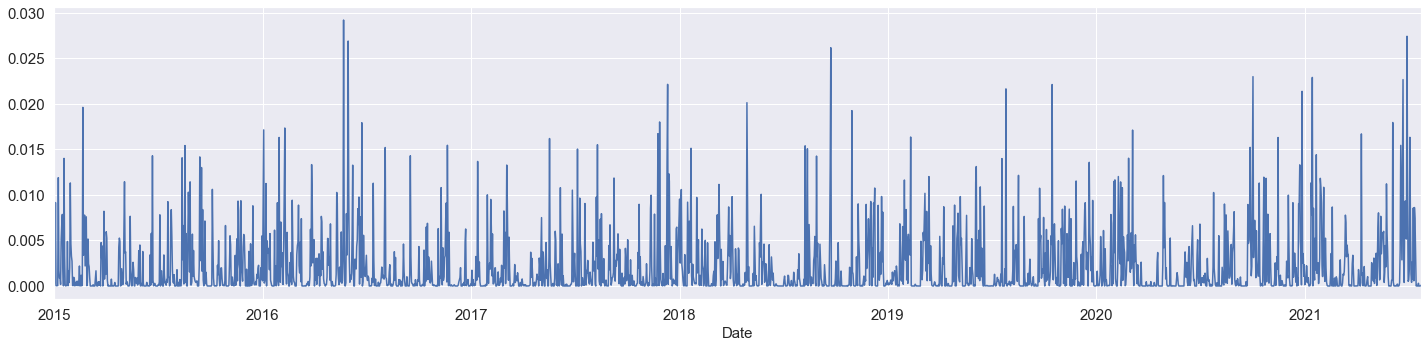

In [20]:
ax = data.tp.plot(figsize=(20, 5), fontsize=FONTSIZE)
ax.set_xlabel('Date', fontsize=FONTSIZE)
plt.tight_layout()
ax.get_figure().savefig(f'Images/piezometre_{bss_id}_rain.pdf')

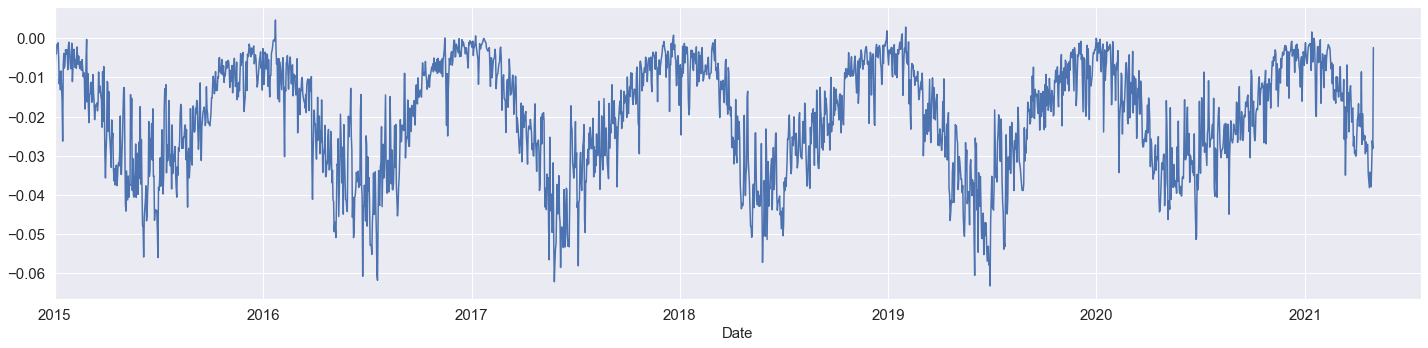

In [38]:
ax = data.e.plot(figsize=(20, 5), fontsize=FONTSIZE)
ax.set_xlabel('Date', fontsize=FONTSIZE)
plt.tight_layout()
ax.get_figure().savefig(f'Images/piezometre_{bss_id}_eto.pdf')

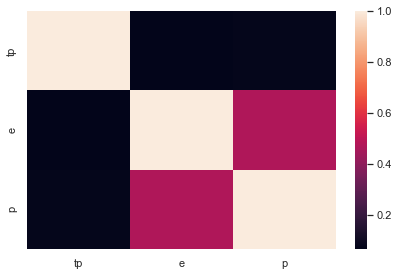

In [28]:
ax = sns.heatmap(data.corr())
plt.tight_layout()
ax.get_figure().savefig(f'Images/piezometre_{bss_id}_corr.pdf')

# Preprocessing

In [29]:
data_no_missing = data.copy()
data_no_missing.e = data_no_missing.e.interpolate(method='linear') # evapotranspiration
data_no_missing.p = data_no_missing.tp.interpolate(method='linear') # pricipitation

# Adding date features
data_no_missing = add_date_features(data)

# First and second degree diff
data_no_missing = add_derivate_features(data_no_missing, 'p')
data_no_missing = add_derivate_features(data_no_missing, 'e')
data_no_missing = add_derivate_features(data_no_missing, 'tp')
data_no_missing

,tp,e,p,year,month,quarter,weekday,day,diff_p,diff30_p,...,diff_e,diff30_e,diff90_e,diff180_e,diff_diff_e,diff_tp,diff30_tp,diff90_tp,diff180_tp,diff_diff_tp
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.000002,-0.002716,11.65,2015,1,1,3,1,0.00,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-02,0.000968,-0.006637,11.61,2015,1,1,4,2,-0.04,0.00,...,-0.003920,0.0,0.0,0.0,-0.003920,0.000966,0.000000,0.000000,0.000000,0.000966
2015-01-03,0.009156,-0.001883,11.56,2015,1,1,5,3,-0.05,0.00,...,0.004753,0.0,0.0,0.0,0.008674,0.008188,0.000000,0.000000,0.000000,0.007223
2015-01-04,0.000030,-0.003922,11.53,2015,1,1,6,4,-0.03,0.00,...,-0.002039,0.0,0.0,0.0,-0.006793,-0.009126,0.000000,0.000000,0.000000,-0.017315
2015-01-05,0.000032,-0.001558,11.49,2015,1,1,0,5,-0.04,0.00,...,0.002364,0.0,0.0,0.0,0.004403,0.000002,0.000000,0.000000,0.000000,0.009128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,0.000000,NaN,11.49,2021,7,3,1,20,0.04,0.91,...,0.000000,0.0,0.0,0.0,0.000000,-0.000301,-0.002869,-0.001025,-0.014404,-0.000602
2021-07-21,0.000000,NaN,11.53,2021,7,3,2,21,0.04,0.92,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,-0.012571,0.000000,-0.001398,0.000301
2021-07-22,0.000000,NaN,11.58,2021,7,3,3,22,0.05,0.94,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,-0.022651,0.000000,-0.002144,0.000000


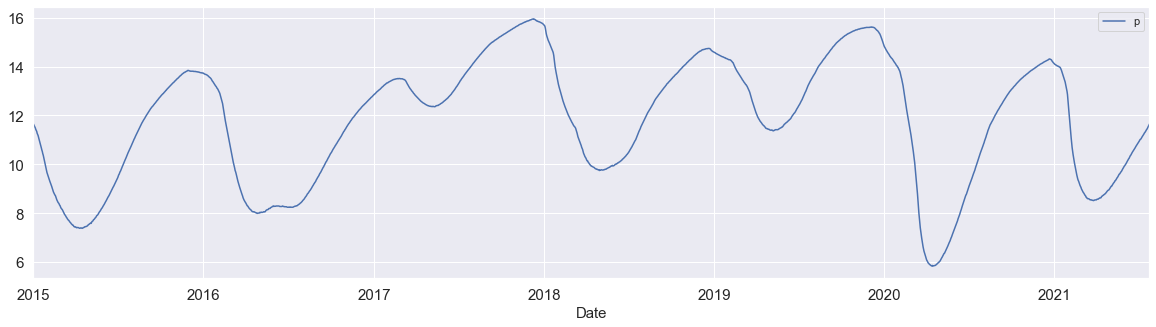

In [30]:
ax = data_no_missing[['p']].plot(label='without missing', figsize=(20, 5), fontsize=FONTSIZE)
ax.set_xlabel('Date', fontsize=FONTSIZE)
plt.show()

### Split dataset 

$70\%$ for training, $20\%$ for validation and $10\%$ for test

In [31]:
features = ['p', 'year', 'month', 'quarter', 'weekday', 'day', 'diff_p', 'diff30_p', 'diff90_p', 'diff180_p', 'diff_diff_p']

for cov_list in [[], ['e'], ['tp'], ['e', 'tp']]:
    for cov in cov_list:
        features.extend([cov, 'diff_'+cov, 'diff30_'+cov, 'diff90_'+cov, 'diff180_'+cov, 'diff_diff_'+cov])

df = data_no_missing[features]

n_features = len(features)

n = df.shape[0]

train_df = df[:-label_width:]

test_df = df[-(label_width+input_width):]

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)
print('Number of observations:', n) 
print('Features:', features, 'number:', n_features)

Train shape: (2304, 35)
Test shape: (193, 35)
Number of observations: 2397
Features: ['p', 'year', 'month', 'quarter', 'weekday', 'day', 'diff_p', 'diff30_p', 'diff90_p', 'diff180_p', 'diff_diff_p', 'e', 'diff_e', 'diff30_e', 'diff90_e', 'diff180_e', 'diff_diff_e', 'tp', 'diff_tp', 'diff30_tp', 'diff90_tp', 'diff180_tp', 'diff_diff_tp', 'e', 'diff_e', 'diff30_e', 'diff90_e', 'diff180_e', 'diff_diff_e', 'tp', 'diff_tp', 'diff30_tp', 'diff90_tp', 'diff180_tp', 'diff_diff_tp'] number: 35


## Data normalization

To do when working with more than one feature

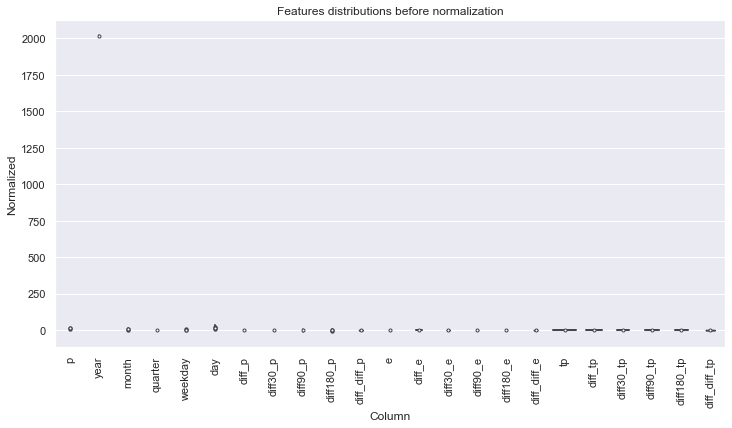

In [62]:
df_tmp = df.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_tmp)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#ax.set_yscale('log')
ax.set_title('Features distributions before normalization');

In [32]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

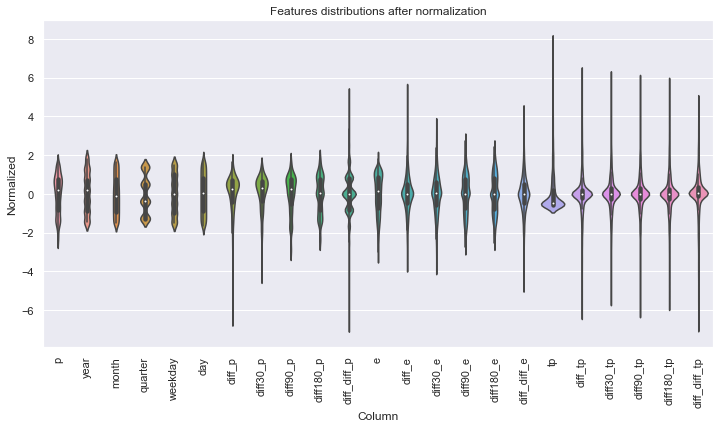

In [33]:
df_norm = (df - train_mean) / train_std
df_norm = df_norm.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_norm)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Features distributions after normalization');

### Data windowing

In [34]:
window = WindowGenerator(input_width=input_width, 
                         label_width=label_width, 
                         shift=shift,
                         batch_size=batch_size,
                         train_df=train_df, test_df=test_df, label_columns=['p'])

no_suffled_window = WindowGenerator(input_width=input_width, 
                         label_width=label_width, 
                         shift=shift,
                         batch_size=batch_size,
                         train_df=train_df, test_df=test_df, label_columns=['p'], shuffle=False)
print(window)

Total window size: 193
History length: 100
Horizon length: 93
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Label indices: [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192]
Label column name(s): ['p']


In [35]:
def plot_forecast(model, name, label_index = None):
    last_history = np.expand_dims(test_df.tail(input_width).values, axis=0)
    
    forecast = model.predict(last_history).squeeze()
    
    if label_index is not None:
        forecast = forecast[:, label_index]
        
    forecast = forecast * train_std['p'] + train_mean['p']
    
    forecast_index = pd.date_range(start=test_df.index[-1], end=test_df.index[-1] + pd.Timedelta(label_width, unit='D'))[1:]

    series = df.p.append(pd.Series(data=forecast, index=forecast_index))

    series.plot(figsize=(20, 5), label='')
    plt.plot(forecast_index, forecast, label='forecast', lw=3)
    plt.legend()
    plt.title(name, fontsize=22)
    plt.show()

# Models

In [36]:
MAX_EPOCHS = 50
patience = 5

In [37]:
train_performance = {}
test_performance = {}
models = {}

## Model 

In [53]:
class RNForecaster(tf.keras.Model):
    def __init__(self, kernel_size, filters, label_width, n_blocks=2, use_batch_norm=False,**kwargs):
        super().__init__(**kwargs)
        self.kernel_size = kernel_size
        self.bn = use_batch_norm
        
        self.conv_init = tf.keras.layers.Conv1D(filters=filters, kernel_size=self.kernel_size, activation='relu', padding='same', name='conv_init')
        self.bn_init = tf.keras.layers.BatchNormalization(name='bn_init')
        
        self.convs = []
        self.bns = []
        self.adds = []
        
        for stage in range(n_blocks):
            conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=self.kernel_size, activation='relu', padding='same', name=f"conv_{stage}")
            self.convs.append(conv)
                
            bn = tf.keras.layers.BatchNormalization(name=f"bn_{stage}")
            self.bns.append(bn)
                
            self.adds.append(tf.keras.layers.Add(name=f'add_{stage}'))
                
                
        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=label_width)
        self.reshape = tf.keras.layers.Reshape((label_width, -1))
        
    def call(self, inputs):
        out = self.conv_init(inputs)
        
        if self.bn:
            out = self.bn_init(out)
            
        for i in range(len(self.convs)):
            out_shortcut = out
            out = self.convs[i](out)
            out = self.bns[i](out)
            out = self.adds[i]([out, out_shortcut])
        
        out = self.flatten(out)
        
        out = self.dropout(out)
        out = self.dense1(out)        
        out = self.dense2(out)
        out = self.reshape(out)
        
        return out
    
    def build_graph(self, input_shape):
        x = tf.keras.layers.Input(shape=(input_shape))
        return tf.keras.models.Model(inputs=[x], outputs=self.call(x))


In [71]:
conv_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(units=label_width),
    tf.keras.layers.Reshape((label_width, -1))
], name='conv2')

In [78]:
CONV_WIDTH = 3
filters = 64
n_blocks = 2
use_bn = True

rnForecaster = RNForecaster(kernel_size=CONV_WIDTH, label_width=label_width, filters=filters, n_blocks=n_blocks, use_batch_norm=use_bn)

history = compile_and_fit(rnForecaster, window, patience=patience, epochs=MAX_EPOCHS)

train_performance['rnForecaster V0'] = rnForecaster.evaluate(window.train)
test_performance['rnForecaster V0'] = rnForecaster.evaluate(np.expand_dims(train_df[-input_width:].values, axis=0), np.expand_dims(test_df.values, axis=0))
models['rnForecaster'] = rnForecaster

1/1 [==============================] - 0s 12ms/step - loss: 1.0243


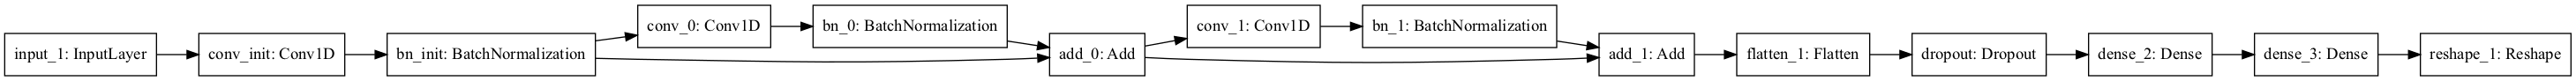

In [37]:
tf.keras.utils.plot_model(rnForecaster.build_graph(window.train.element_spec[0].shape[1:]), 'Images/RNForecaster.png', rankdir='LR')

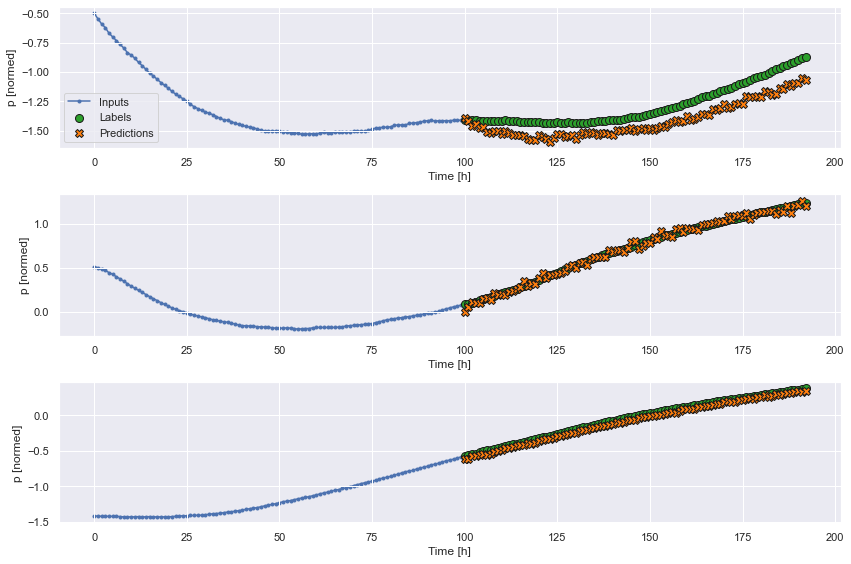

In [38]:
window.plot(rnForecaster, plot_col='p')

In [77]:
conv_model2.predict(window.test).squeeze()

array([-1.4883593 , -1.5040632 , -1.5010532 , -1.4500122 , -1.5112278 ,
       -1.4277675 , -1.3841627 , -1.3284646 , -1.4176271 , -1.4217072 ,
       -1.5347174 , -1.36414   , -1.2682905 , -1.3324678 , -1.3343937 ,
       -1.3162695 , -1.2931873 , -1.221593  , -1.251013  , -1.2125762 ,
       -1.1303097 , -1.0535066 , -1.1817873 , -1.0912265 , -1.0680976 ,
       -1.0492921 , -1.1287646 , -1.0191189 , -1.0077969 , -1.0522417 ,
       -1.0449842 , -0.89795643, -1.0296673 , -0.97230905, -0.92588437,
       -0.8887275 , -0.8993918 , -0.8301637 , -0.81079805, -0.75569046,
       -0.88201964, -0.7679355 , -0.7196214 , -0.66685116, -0.6412158 ,
       -0.7387941 , -0.6020049 , -0.63229436, -0.64055926, -0.60424715,
       -0.5088184 , -0.5678716 , -0.45262244, -0.47940823, -0.4638746 ,
       -0.47462878, -0.50563157, -0.43610457, -0.36465746, -0.35468876,
       -0.32950938, -0.32267022, -0.36191192, -0.37348884, -0.19547746,
       -0.2705446 , -0.23770808, -0.19407195, -0.23688976, -0.22

In [73]:
conv_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(units=label_width),
    tf.keras.layers.Reshape((label_width, -1))
], name='conv2')

history = compile_and_fit(conv_model2, window, patience=patience, epochs=MAX_EPOCHS)

train_performance['Conv2'] = conv_model2.evaluate(window.train)
test_performance['Conv2'] = conv_model2.evaluate(window.test)
models['conv2'] = conv_model2

Epoch 1/50
33/33 [==============================] - 2s 35ms/step - loss: 0.4471
Epoch 2/50
33/33 [==============================] - 1s 35ms/step - loss: 0.0439
Epoch 3/50
33/33 [==============================] - 1s 35ms/step - loss: 0.0171
Epoch 4/50
33/33 [==============================] - 1s 36ms/step - loss: 0.0096
Epoch 5/50
33/33 [==============================] - 1s 36ms/step - loss: 0.0066
Epoch 6/50
33/33 [==============================] - 1s 35ms/step - loss: 0.0048
Epoch 7/50
33/33 [==============================] - 1s 35ms/step - loss: 0.0040
Epoch 8/50
33/33 [==============================] - 1s 36ms/step - loss: 0.0032
Epoch 9/50
33/33 [==============================] - 1s 35ms/step - loss: 0.0028
Epoch 10/50
33/33 [==============================] - 1s 35ms/step - loss: 0.0024
Epoch 11/50
33/33 [==============================] - 1s 37ms/step - loss: 0.0021
Epoch 12/50
33/33 [==============================] - 1s 34ms/step - loss: 0.0019
Epoch 13/50
33/33 [==================

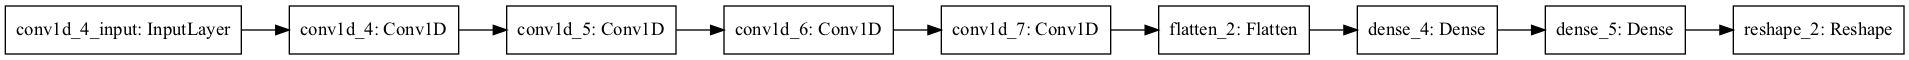

In [40]:
tf.keras.utils.plot_model(conv_model2, 'Images/Conv2.png', rankdir='LR')

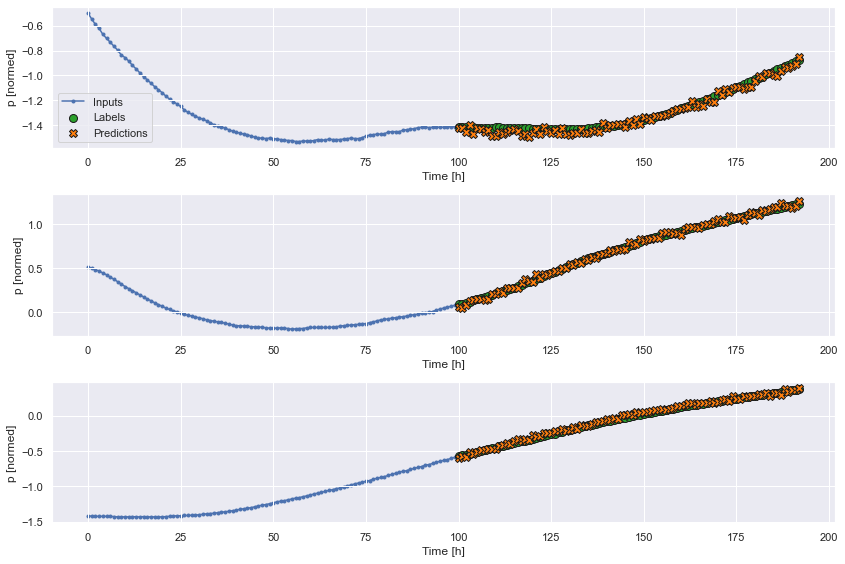

In [41]:
window.plot(conv_model2, plot_col='p')

In [42]:
conv_model3 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu', padding='same'),
    tf.keras.layers.AveragePooling1D(3),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    tf.keras.layers.AveragePooling1D(3),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.AveragePooling1D(3),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.AveragePooling1D(3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(units=label_width),
    tf.keras.layers.Reshape((label_width, -1))
], name='conv3')

history = compile_and_fit(conv_model3, window, patience=patience, epochs=MAX_EPOCHS)

train_performance['Conv3'] = conv_model3.evaluate(window.train)
test_performance['Conv3'] = conv_model3.evaluate(np.expand_dims(train_df[-input_width:].values, axis=0), np.expand_dims(test_df.values, axis=0))
models['conv3'] = conv_model3

1/1 [==============================] - 0s 93ms/step - loss: 1.7951


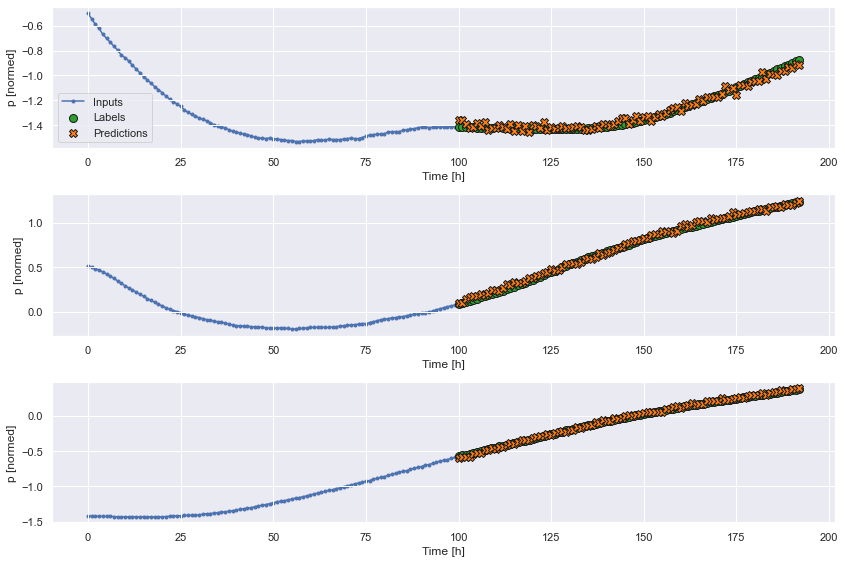

In [43]:
window.plot(conv_model3, plot_col='p')

In [44]:
conv_model4 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=7, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(units=label_width),
    tf.keras.layers.Reshape((label_width, -1))
], name='conv4')

history = compile_and_fit(conv_model4, window, patience=patience, epochs=MAX_EPOCHS)

train_performance['Conv4'] = conv_model4.evaluate(window.train)
test_performance['Conv4'] = conv_model4.evaluate(np.expand_dims(train_df[-input_width:].values, axis=0), np.expand_dims(test_df.values, axis=0))
models['conv4'] = conv_model4

1/1 [==============================] - 0s 94ms/step - loss: 1.6111


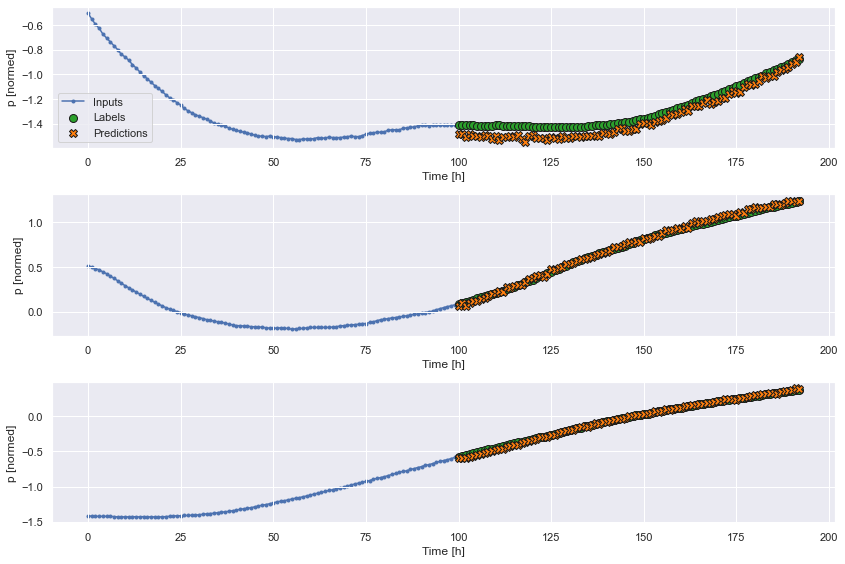

In [45]:
window.plot(conv_model4, plot_col='p')

In [47]:
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(units=label_width),
    tf.keras.layers.Reshape((label_width, -1))
], name='lstm2')

history = compile_and_fit(lstm_model2, no_suffled_window, patience=patience, epochs=MAX_EPOCHS)

train_performance['LSTM 2'] = lstm_model2.evaluate(window.train)
test_performance['LSTM 2'] = lstm_model2.evaluate(np.expand_dims(train_df[-input_width:].values, axis=0), np.expand_dims(test_df.values, axis=0))
models['LSTM 2'] = lstm_model2

1/1 [==============================] - 0s 420ms/step - loss: 1.6210


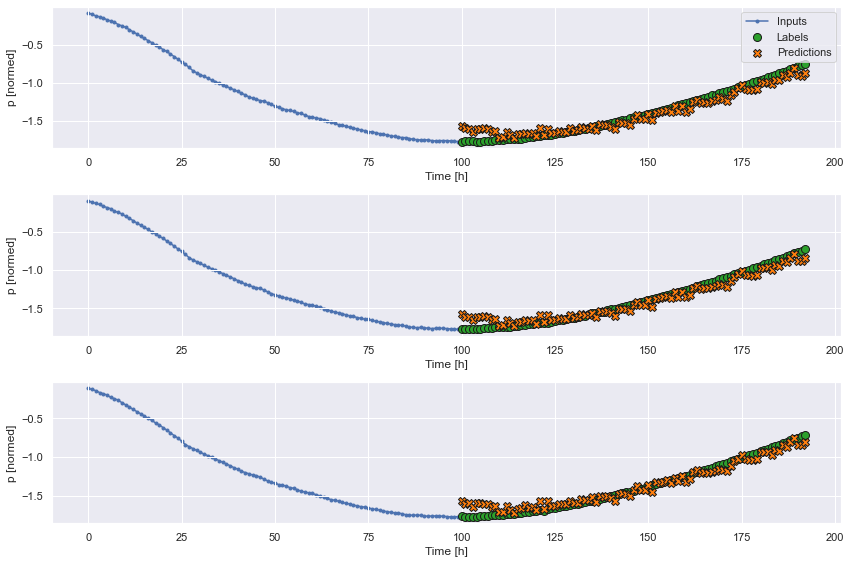

In [48]:
no_suffled_window.plot(lstm_model2, plot_col='p')

# Trying other models

In [46]:
from prophet import Prophet
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR", "INFO")

from mxnet import gluon
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deepstate import DeepStateEstimator

from gluonts.mx import Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator

In [9]:
dd = all_data.loc['00068X0147/PZ5']
dd = pd.DataFrame({'ds': dd.time, 'y': dd.p, 'e': dd.e, 'tp': dd.tp})
dd.e = dd.e.interpolate()
dd.tp = dd.tp.interpolate()
dd.head()

,ds,y,e,tp
bss,,,,
00068X0147/PZ5,2015-01-01,5.54,-0.005224,4.032627e-07
00068X0147/PZ5,2015-01-02,5.45,-0.008807,4.143920e-04
00068X0147/PZ5,2015-01-03,5.24,-0.005555,1.245819e-02
00068X0147/PZ5,2015-01-04,5.28,-0.005761,8.401461e-06
00068X0147/PZ5,2015-01-05,5.11,-0.002160,3.353972e-05


## NeuralProphet

In [12]:
neural_prophet_model = NeuralProphet(n_lags=5, n_forecasts=1)
neural_prophet_model.add_lagged_regressor(['e', 'tp'])

metrics = neural_prophet_model.fit(dd[:-label_width], freq='D')

future = neural_prophet_model.make_future_dataframe(dd[:-label_width], periods=label_width)
neural_prophet_predictions = neural_prophet_model.predict(dd)

n_lags = sum(neural_prophet_predictions.yhat1.values == None)

# train_performance['NeuralProphet'] = tf.keras.metrics.mean_squared_error(neural_prophet_predictions.yhat1.astype(float)[n_lags:-label_width], dd[n_lags:-label_width].y).numpy()
# test_performance['NeuralProphet'] = tf.keras.metrics.mean_squared_error(neural_prophet_predictions.yhat1[-label_width:], dd[-label_width:].y).numpy()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.957% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 45


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.25E-02, min: 1.20E+00


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.56E-02, min: 1.30E+00


  0%|          | 0/268 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.56E-02, min: 1.40E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.79E-02
Epoch[45/45]: 100%|█| 45/45 [00:05<00:00,  8.42it/s, SmoothL1Loss=0.000101, MAE=
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.957% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
WARNING - (py.warnings._showwarnmsg) - /home/mimbouop/anaconda3/envs/defiegc2021/lib/python3.8/site-packages/neuralprophet/forecaster.py:1618: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.958% of the data.
INFO - (NP.df_utils._infer_freque

## Global NeuralProphet

In [93]:
df_train_dict[piezos[0]].shape

(2304, 4)

In [95]:
future = global_neural_prophet.make_future_dataframe(df_train_dict[piezos[0]], periods=93)
future

WARNING - (py.warnings._showwarnmsg) - /home/mimbouop/anaconda3/envs/defiegc2021/lib/python3.8/site-packages/neuralprophet/forecaster.py:1618: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)



,ds,y,tp,e
bss,,,,
00065X0148/P,2015-01-01,0.89,0.000015,-0.005951
00065X0148/P,2015-01-02,0.95,0.000791,-0.012997
00065X0148/P,2015-01-03,0.72,0.012880,-0.009395
00065X0148/P,2015-01-04,0.70,0.000005,-0.007145
00065X0148/P,2015-01-05,0.78,0.000072,-0.002743
...,...,...,...,...
00065X0148/P,2021-04-18,1.49,0.000000,-0.023477
00065X0148/P,2021-04-19,1.50,0.000002,-0.021776
00065X0148/P,2021-04-20,1.63,0.000039,-0.020622


In [96]:
# Global neural prophet
piezos = pd.read_csv('../results/all-performance.csv', usecols=[0], squeeze=True)
df_train_dict = {}
df_test_dict = {}
for bss in piezos[:3]:
    aux = all_data.loc[bss].copy()
    tmp = pd.DataFrame({'ds': aux.time[:-label_width], 'y': aux.p[:-label_width], 'tp': aux.tp[:-label_width], 'e': aux.e[:-label_width]})
    tmp.e = tmp.e.interpolate()
    tmp.tp = tmp.tp.interpolate()
    df_train_dict[bss] = tmp
    
    tmp = pd.DataFrame({'ds': aux.time[-label_width:], 'y': aux.p[-label_width:], 'tp': aux.tp[-label_width:], 'e': aux.e[-label_width:]})
    tmp.e = tmp.e.interpolate()
    tmp.tp = tmp.tp.interpolate()
    df_test_dict[bss] = tmp

global_neural_prophet = NeuralProphet(global_normalization=True, n_lags=label_width-1, n_forecasts=1)
global_neural_prophet.add_lagged_regressor(['e', 'tp'])

fit_metrics = global_neural_prophet.fit(df_train_dict, freq='D')

train_metrics = global_neural_prophet.test(df_train_dict)
test_metrics = global_neural_prophet.test(df_test_dict)

pd.concat([train_metrics, test_metrics], keys=['train', 'test'])

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_15231/3485405655.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  piezos = pd.read_csv('../results/all-performance.csv', usecols=[0], squeeze=True)



  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

,,SmoothL1Loss,MAE,RMSE
train,0,0.003303,1.632651,2.070503
test,0,0.063274,9.061503,9.074827


In [91]:
global_neural_prophet.test(df_test_dict['00065X0148/P'])['RMSE'][0]

5.745724201202393

In [53]:
pd.DataFrame(index=['idddd'], data=[np.arange(100, 200)])

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
idddd,100,101,102,103,104,105,106,107,108,109,...,190,191,192,193,194,195,196,197,198,199


In [68]:
pred_dict = {
    '1': np.arange(10),
    '2': np.arange(20, 30)
}
pd.DataFrame(pred_dict).T

,0,1,2,3,4,5,6,7,8,9
1,0,1,2,3,4,5,6,7,8,9
2,20,21,22,23,24,25,26,27,28,29


In [70]:
pd.DataFrame({'mse': {'1': 1, '2': 25}, 'rmse': {'1': 1555, '2': 2555}, 'learningtime': 25}).join(pd.DataFrame(pred_dict, index=['A']*10).T)

,mse,rmse,learningtime,A,A,A,A,A,A,A,A,A,A
1,1,1555,25,0,1,2,3,4,5,6,7,8,9
2,25,2555,25,20,21,22,23,24,25,26,27,28,29


## Prophet

In [39]:
prophet_model = Prophet()
prophet_model.add_regressor('e')
metrics = prophet_model.fit(dd[:-label_width])

prophet_predictions = prophet_model.predict(dd)

train_performance['Prophet'] = tf.keras.metrics.mean_squared_error(prophet_predictions.yhat[:-label_width], dd[:-label_width].y).numpy()
test_performance['Prophet'] = tf.keras.metrics.mean_squared_error(prophet_predictions.yhat[-label_width:], dd[-label_width:].y).numpy()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ValueError: Found NaN in column 'e'

## DeepAR

In [147]:
FREQ = 'D'

train_ds = ListDataset(
    [{'target': dd.y[:-len_test], 'start': '2015-01-01'}],
    freq=FREQ
)
# test dataset
test_ds = ListDataset(
    [{'target': dd.y, 'start': '2015-01-01'}],
    freq=FREQ
)

estimator = DeepAREstimator(
        prediction_length=label_width,
        context_length=input_width,
        freq=FREQ,
        trainer=Trainer(
            epochs=MAX_EPOCHS,
            patience=patience,
            num_batches_per_epoch=batch_size)
    )

"""
estimator = DeepStateEstimator(
        prediction_length=label_width,
        cardinality=[1],
        past_length=input_width,
        freq=FREQ,
        trainer=Trainer(
            epochs=MAX_EPOCHS,
            patience=patience,
            num_batches_per_epoch=batch_size)
    )
"""

predictor = estimator.train(train_ds)

forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
    )

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=1)

WARNING - (py.warnings._showwarnmsg) - /Users/michael/opt/miniconda3/envs/defiegc2021/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)

  return _shift_timestamp_helper(ts, ts.freq, offset)

WARNING - (py.warnings._showwarnmsg) - /Users/michael/opt/miniconda3/envs/defiegc2021/lib/python3.9/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq

  self._min_time_point, self._max_time_point, freq=start.freq

  0%|          | 0/64 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/michael/opt/miniconda3/envs/defiegc2021/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts,

In [152]:
forecasts[0].samples[0]

array([0.742301  , 0.7469821 , 0.7717891 , 0.8268093 , 0.7694138 ,
       0.7432917 , 0.6621235 , 0.61874557, 0.70173717, 0.6892347 ,
       0.7270475 , 0.761099  , 0.7544437 , 0.76901495, 0.7420308 ,
       0.6671804 , 0.70499766, 0.6795949 , 0.6147276 , 0.6619451 ,
       0.68672955, 0.7008101 , 0.7089567 , 0.72066903, 0.7022249 ,
       0.724839  , 0.7693397 , 0.76137614, 0.6220022 , 0.60712034,
       0.5901127 , 0.57734567, 0.5675874 , 0.75714153, 0.7089003 ,
       0.6497054 , 0.604379  , 0.6671747 , 0.6802897 , 0.6787294 ,
       0.60941446, 0.6781465 , 0.70067155, 0.7308774 , 0.72662914,
       0.73393196, 0.7251652 , 0.7537721 , 0.7806048 , 0.7285507 ,
       0.7539323 , 0.7817439 , 0.81093824, 0.75941014, 0.76160735,
       0.7857549 , 0.8185825 , 0.8299315 , 0.7716712 , 0.78230727,
       0.7518384 , 0.77936167, 0.79966486, 0.7807858 , 0.4527003 ,
       0.46926335, 0.57258487, 0.58549297, 0.52899617, 0.5669935 ,
       0.5662338 , 0.6504804 , 0.6661985 , 0.7097949 , 0.65058

,train_loss,test_loss
rnForecaster V0,0.004132,1.024268
Conv2,0.000856,1.302251
Conv3,0.001829,1.795059
Conv4,0.001447,1.611079
LSTM 2,0.053211,1.621033
NeuralProphet,0.080490,0.158035
Prophet,0.085267,0.570219
DeepAR,0.001189,0.019035


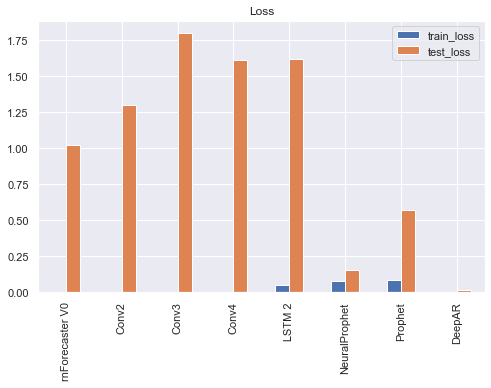

In [185]:
df_results = pd.DataFrame({'train_loss': train_performance, 'test_loss': test_performance})

df_results.plot(kind='bar', title='Loss', figsize=(8, 5));

df_results

## Ploting forecasts

In [85]:
for name, model in models.items():
    label_index = window.column_indices['p'] if 'AR' in name else None
    plot_forecast(model, name, label_index=label_index)

InvalidArgumentError:  Matrix size-incompatible: In[0]: [1,5952], In[1]: [6400,256]
	 [[node rn_forecaster/dense_2/Relu (defined at <ipython-input-31-11427ab7ec1c>:45) ]] [Op:__inference_predict_function_64265]

Function call stack:
predict_function
